In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('/Users/jamalbacchus/IdeaProjects/Capstone/dataset/student/student-por.csv'
                   , sep = ';')
len(data)

649

In [3]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [4]:
# generate binary label (pass/fail) based on G1 + G2 + G3 (test grades, each 0-20 pts); threshold for passing is sum >= 30

data['pass'] = data.apply(lambda row: 1 if (row['G1']+row['G2']+row['G3']) >= 35 else 0, axis = 1)
data = data.drop(['G1', 'G2', 'G3'], axis = 1)
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,4,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,2,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,6,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,0,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,0,1


In [5]:
# use one-hot encoding on categorical columns
data = pd.get_dummies(data, columns=['sex', 'school', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                                     'internet', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                                     'activities', 'nursery', 'higher', 'romantic'])
data.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,paid_no,paid_yes,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1,0,1,0,0,1,0,1,1,0
1,17,1,1,1,2,0,5,3,3,1,...,1,0,1,0,1,0,0,1,1,0
2,15,1,1,1,2,0,4,3,2,2,...,1,0,1,0,0,1,0,1,1,0
3,15,4,2,1,3,0,3,2,2,1,...,1,0,0,1,0,1,0,1,0,1
4,16,3,3,1,2,0,4,3,2,1,...,1,0,1,0,0,1,0,1,1,0


In [9]:
# shuffle rows
data = data.sample(frac = 1)
# split training and testing data
data_train = data[:500]
data_test = data[500:]

data_train_att = data_train.drop(['pass'], axis = 1)
data_train_pass = data_train['pass']

data_test_att = data_test.drop(['pass'], axis = 1)
data_test_pass = data_test['pass']

data_att = data.drop(['pass'], axis = 1)
data_pass = data['pass']

# number of passing students in while dataset;
import numpy as np
print("Passing: %d out of %d (%.2f%%)" % (np.sum(data_pass),
                                         len(data_pass), 100*float(np.sum(data_pass)) / len(data_pass)))

Passing: 328 out of 649 (50.54%)


In [10]:
# fit a decision tree
from sklearn import tree
t = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 5)
t = t.fit(data_train_att, data_train_pass)

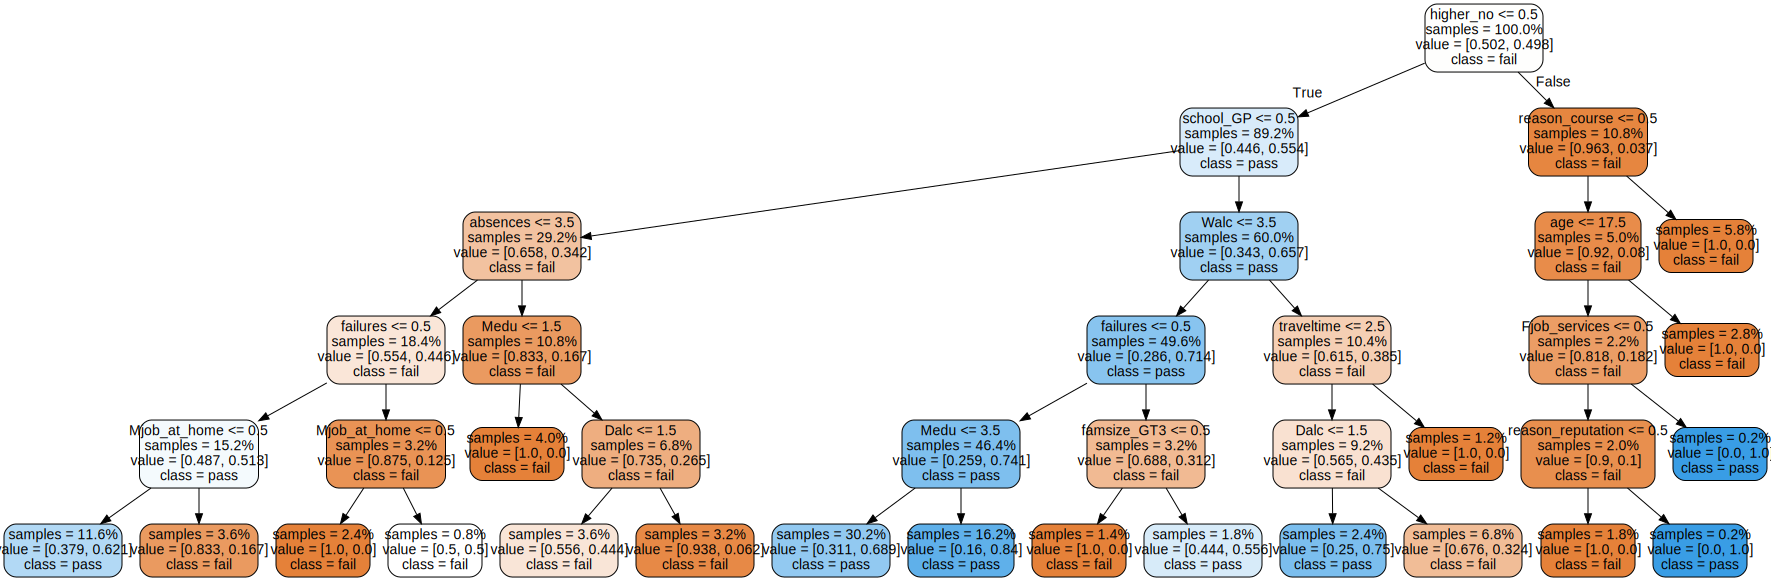

In [16]:
# visualize tree
import graphviz
dot_data = tree.export_graphviz(t, out_file=None, label="all", impurity=False, proportion=True,
                               feature_names=list(data_train_att), class_names=["fail", "pass"],
                               filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [18]:
t.score(data_test_att, data_test_pass)

0.70469798657718119

In [19]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(t, data_att, data_pass, cv=5)
# show average score and +/- two standard deviations away (coverung 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.03)


In [20]:
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, data_att, data_pass, cv=5)
    print("Max depth: %d, Accuracy: %0.2f (+/- %0.2f)" % (max_depth, scores.mean(), scores.std() * 2))

Max depth: 1, Accuracy: 0.62 (+/- 0.07)
Max depth: 2, Accuracy: 0.66 (+/- 0.10)
Max depth: 3, Accuracy: 0.69 (+/- 0.05)
Max depth: 4, Accuracy: 0.70 (+/- 0.02)
Max depth: 5, Accuracy: 0.67 (+/- 0.03)
Max depth: 6, Accuracy: 0.67 (+/- 0.04)
Max depth: 7, Accuracy: 0.65 (+/- 0.11)
Max depth: 8, Accuracy: 0.64 (+/- 0.08)
Max depth: 9, Accuracy: 0.65 (+/- 0.10)
Max depth: 10, Accuracy: 0.65 (+/- 0.12)
Max depth: 11, Accuracy: 0.63 (+/- 0.07)
Max depth: 12, Accuracy: 0.64 (+/- 0.10)
Max depth: 13, Accuracy: 0.64 (+/- 0.10)
Max depth: 14, Accuracy: 0.63 (+/- 0.11)
Max depth: 15, Accuracy: 0.64 (+/- 0.09)
Max depth: 16, Accuracy: 0.62 (+/- 0.07)
Max depth: 17, Accuracy: 0.64 (+/- 0.10)
Max depth: 18, Accuracy: 0.62 (+/- 0.12)
Max depth: 19, Accuracy: 0.62 (+/- 0.09)


In [21]:
depth_acc = np.empty((19,3), float)
i = 0
for max_depth in range(1, 20):
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    scores = cross_val_score(t, data_att, data_pass, cv=5)
    depth_acc[i,0] = max_depth
    depth_acc[i,1] = scores.mean()
    depth_acc[i,2] = scores.std() * 2
    i += 1
    
depth_acc

array([[  1.        ,   0.61797412,   0.07022814],
       [  2.        ,   0.65647253,   0.09275723],
       [  3.        ,   0.69329009,   0.058115  ],
       [  4.        ,   0.70108991,   0.02571689],
       [  5.        ,   0.67184631,   0.02955322],
       [  6.        ,   0.67026014,   0.03422917],
       [  7.        ,   0.63623492,   0.11883922],
       [  8.        ,   0.65466213,   0.07768428],
       [  9.        ,   0.64377364,   0.12309866],
       [ 10.        ,   0.65300496,   0.10745104],
       [ 11.        ,   0.63462581,   0.07696059],
       [ 12.        ,   0.64380924,   0.09349611],
       [ 13.        ,   0.64068461,   0.11775803],
       [ 14.        ,   0.63447186,   0.13380313],
       [ 15.        ,   0.62532385,   0.09548851],
       [ 16.        ,   0.61757209,   0.1142892 ],
       [ 17.        ,   0.65002253,   0.0801606 ],
       [ 18.        ,   0.61761907,   0.09872233],
       [ 19.        ,   0.62073159,   0.08523081]])

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.errorbar(depth_acc[:,0], depth_acc[:,1], yerr=depth_acc[:,2])
plt.show()

<Figure size 640x480 with 1 Axes>